# Introduction:

Weather prediction is a crucial aspect of daily life, affecting everything from agriculture to transportation to emergency preparedness. While traditional forecasting methods have come a long way, there is still much room for improvement in accuracy and efficiency. In recent years, machine learning (ML) has emerged as a promising approach to weather prediction. By leveraging the vast amounts of data collected from weather stations around the world, ML models can analyze complex patterns and relationships to make more accurate and timely predictions.

In this research paper, we explore the application of ML to weather prediction. Specifically, we focus on the use of supervised learning algorithms, including decision trees, logistic regression, and k-nearest neighbors, to predict weather conditions based on historical data. We use a dataset containing daily weather measurements from multiple weather stations in a particular region and train our ML models on this data to predict future weather conditions.

Our research aims to address several key questions, including: What types of ML algorithms are best suited for weather prediction? How does the size and quality of the training dataset affect the accuracy of the predictions? What features or variables have the most significant impact on weather prediction accuracy? By answering these questions, we hope to shed light on the potential of ML for weather prediction and provide insights into best practices for using these technologies in real-world applications.

Overall, this research has the potential to make a significant contribution to the field of weather prediction and inform future research in this area. By demonstrating the effectiveness of ML for predicting weather conditions, we hope to inspire further exploration and innovation in this important domain.

*   In this report, we will use the "seattle-weather.csv" dataset from Kaggle to analyze and build predictive models of weather conditions based on accompanying conditions. This is a set of weather data in the US state of Seattle recorded on a daily basis for about 4 years, includes weather conditions such as observed date, high and low temperature, precipitation, speed wind and weather conditions of the day associated with those conditions. [Link dataset from Kaggle](https://www.kaggle.com/datasets/ananthr1/weather-prediction)

*   Models used: Logistic Regression, Decision Tree, K-Nearest Neighbor Classifier (KNN).

# **Import Library**

imports necessary libraries such as numpy, pandas, seaborn, etc. for data manipulation, visualization, statistical analysis, and machine learning.

In [1]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.tree import plot_tree

# **Retrieve the Dataset**

Use the open meteo API to get the data: https://open-meteo.com/en/docs#hourly=temperature_2m,relative_humidity_2m,rain,snowfall 

In [2]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Make sure all required weather variables are listed here
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 48.2085,
    "longitude": 16.3721,
    "start_date": "2010-06-10",
    "end_date": "2024-06-24",
    "hourly": ["temperature_2m", "relative_humidity_2m", "precipitation", "rain", "snowfall", "cloud_cover", "wind_speed_10m"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()
hourly_rain = hourly.Variables(3).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(4).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(5).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(6).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
    start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
    end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
    freq=pd.Timedelta(seconds=hourly.Interval()),
    inclusive="left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m

hourly_dataframe = pd.DataFrame(data=hourly_data)
hourly_dataframe.set_index('date', inplace=True)

# Aggregate hourly data into daily data
daily_dataframe = hourly_dataframe.resample('D').agg({
    'temperature_2m': ['min', 'max', 'mean'],
    'relative_humidity_2m': ['min', 'max', 'mean'],
    'precipitation': lambda x: 1 if x.sum() > 0 else 0,
    'rain': 'sum',
    'snowfall': 'sum',
    'cloud_cover': ['min', 'max', 'mean'],
    'wind_speed_10m': ['min', 'max', 'mean']
})

# Flatten the multi-index columns
daily_dataframe.columns = ['_'.join(col).strip() for col in daily_dataframe.columns.values]
print(daily_dataframe.head())

Coordinates 48.18980407714844°N 16.377296447753906°E
Elevation 196.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                           temperature_2m_min  temperature_2m_max  \
date                                                                
2010-06-10 00:00:00+00:00           18.119501           29.719501   
2010-06-11 00:00:00+00:00           16.869501           31.719501   
2010-06-12 00:00:00+00:00           20.069500           30.919500   
2010-06-13 00:00:00+00:00           17.919500           22.569500   
2010-06-14 00:00:00+00:00           13.169499           20.769501   

                           temperature_2m_mean  relative_humidity_2m_min  \
date                                                                       
2010-06-10 00:00:00+00:00            23.950750                 50.408783   
2010-06-11 00:00:00+00:00            24.296585                 46.829342   
2010-06-12 00:00:00+00:00            25.048668                 50.247322   
2010-06-1

# **Understanding the Dataset**

Daten beschreiben

In [3]:
# Display the first five rows of the DataFrame
print(daily_dataframe.head())

                           temperature_2m_min  temperature_2m_max  \
date                                                                
2010-06-10 00:00:00+00:00           18.119501           29.719501   
2010-06-11 00:00:00+00:00           16.869501           31.719501   
2010-06-12 00:00:00+00:00           20.069500           30.919500   
2010-06-13 00:00:00+00:00           17.919500           22.569500   
2010-06-14 00:00:00+00:00           13.169499           20.769501   

                           temperature_2m_mean  relative_humidity_2m_min  \
date                                                                       
2010-06-10 00:00:00+00:00            23.950750                 50.408783   
2010-06-11 00:00:00+00:00            24.296585                 46.829342   
2010-06-12 00:00:00+00:00            25.048668                 50.247322   
2010-06-13 00:00:00+00:00            20.627834                 66.462067   
2010-06-14 00:00:00+00:00            18.098667              

In [4]:
# Print information about the data
daily_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5129 entries, 2010-06-10 00:00:00+00:00 to 2024-06-24 00:00:00+00:00
Freq: D
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   temperature_2m_min         5129 non-null   float32
 1   temperature_2m_max         5129 non-null   float32
 2   temperature_2m_mean        5129 non-null   float32
 3   relative_humidity_2m_min   5129 non-null   float32
 4   relative_humidity_2m_max   5129 non-null   float32
 5   relative_humidity_2m_mean  5129 non-null   float32
 6   precipitation_<lambda>     5129 non-null   int64  
 7   rain_sum                   5129 non-null   float32
 8   snowfall_sum               5129 non-null   float32
 9   cloud_cover_min            5129 non-null   float32
 10  cloud_cover_max            5129 non-null   float32
 11  cloud_cover_mean           5129 non-null   float32
 12  wind_speed_10m_min         5129 non-null   float

# **Visualize data**

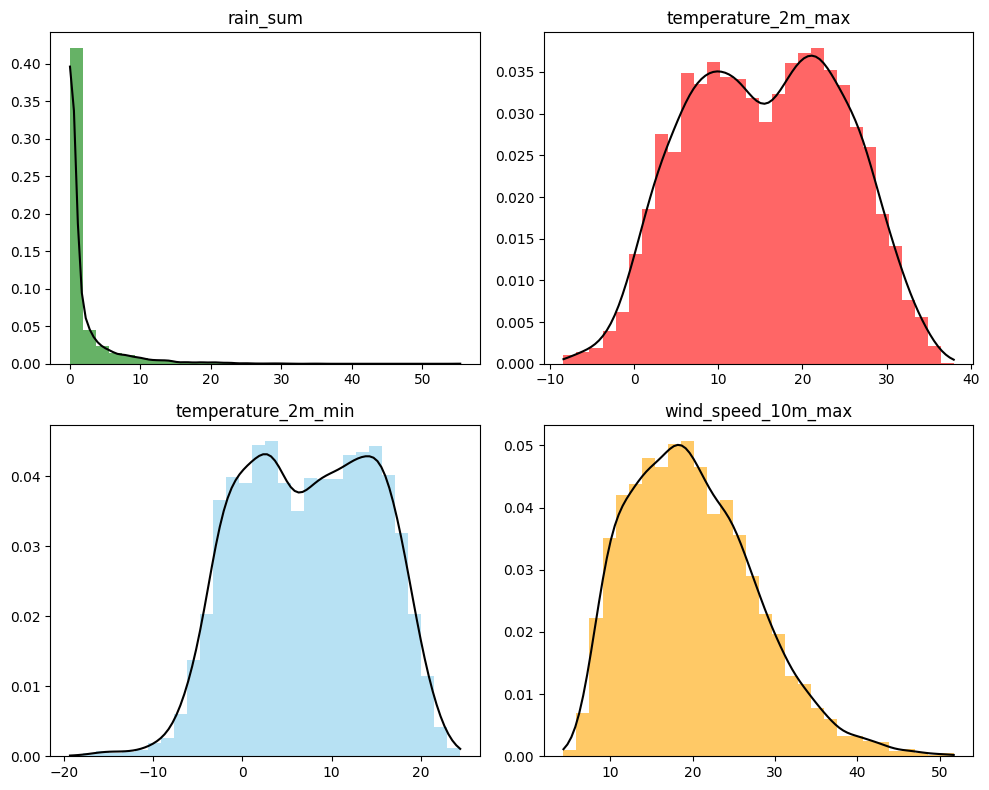

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

# Assuming daily_dataframe is already loaded
# Replace this with the actual loading code if needed
# daily_dataframe = pd.read_csv('your_file.csv')

# Define the variables and colors for the subplots
variables = [
    'rain_sum',
    'temperature_2m_max',
    'temperature_2m_min',
    'wind_speed_10m_max'
]
colors = ["green", "red", "skyblue", "orange"]

# Create the subplots using a loop
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, var in enumerate(variables):
    column = daily_dataframe[var]
    ax = axs[i // 2, i % 2]
    ax.hist(column, bins=30, color=colors[i], alpha=0.6, density=True)
    ax.set_title(f'{var}')
    
    # Add KDE plot
    density = gaussian_kde(column)
    x_vals = np.linspace(min(column), max(column), 100)
    ax.plot(x_vals, density(x_vals), color='black')

plt.tight_layout()
plt.show()



# **CLASSIFICATION MODEL WITH RANDOM FOREST METHOD**

preproces data

              precision    recall  f1-score   support

           0       0.76      0.73      0.74       484
           1       0.77      0.79      0.78       542

    accuracy                           0.76      1026
   macro avg       0.76      0.76      0.76      1026
weighted avg       0.76      0.76      0.76      1026

[[353 131]
 [113 429]]


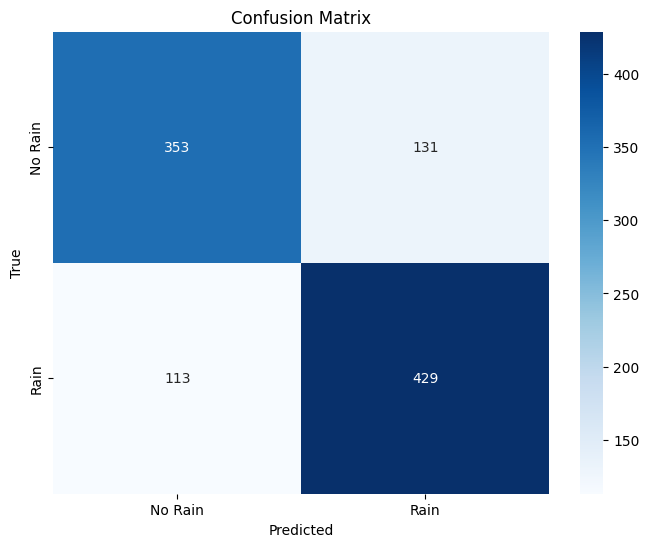

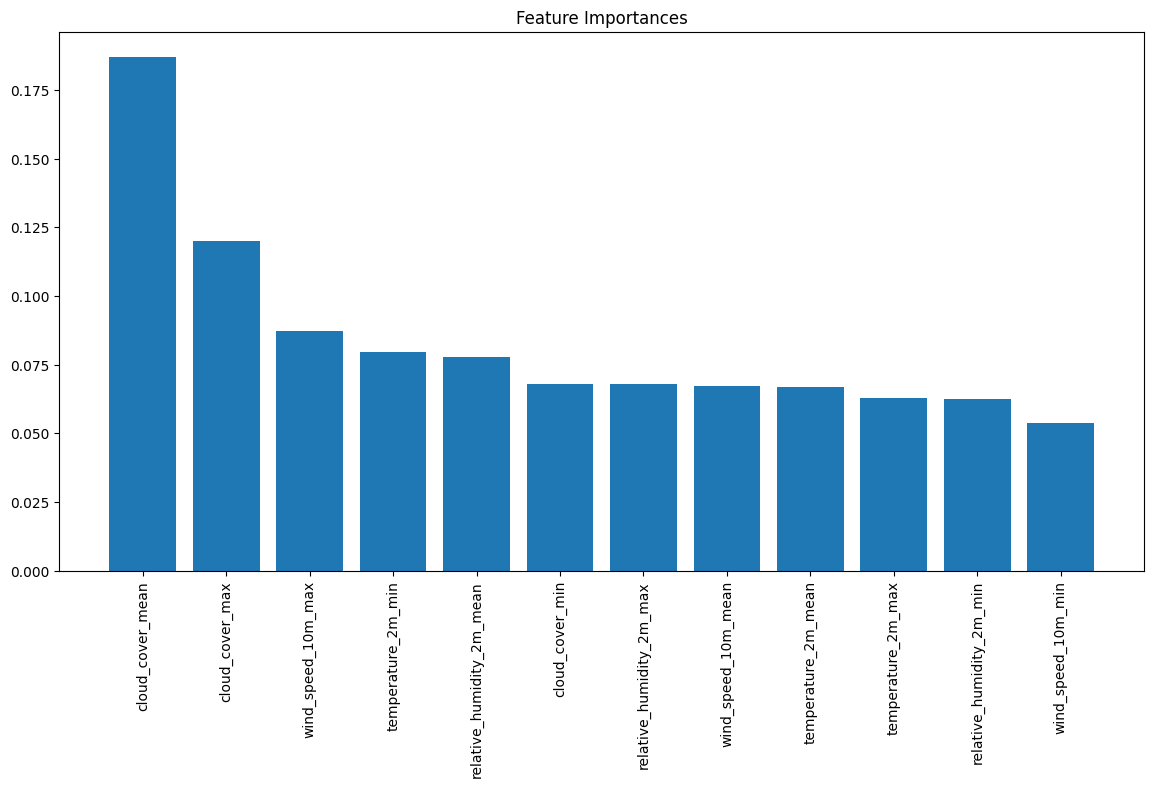

In [6]:
# Define features and target variable
target = 'precipitation_<lambda>'
features = [col for col in daily_dataframe.columns if col != target and col not in ['rain_sum', 'snowfall_sum']]
X = daily_dataframe[features]
y = daily_dataframe[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importance visualization
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(14, 7))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# Visualize the first tree in the Random Forest
plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], feature_names=features, class_names=['No Rain', 'Rain'], filled=True, rounded=True)
plt.title("First Tree in the Random Forest (Precipitation Classification)")
plt.show()

# **CLASSIFICATION MODEL WITH LOGISTIC REGRESSION**

preproces data

              precision    recall  f1-score   support

           0       0.76      0.69      0.72       484
           1       0.75      0.80      0.77       542

    accuracy                           0.75      1026
   macro avg       0.75      0.75      0.75      1026
weighted avg       0.75      0.75      0.75      1026

[[336 148]
 [108 434]]


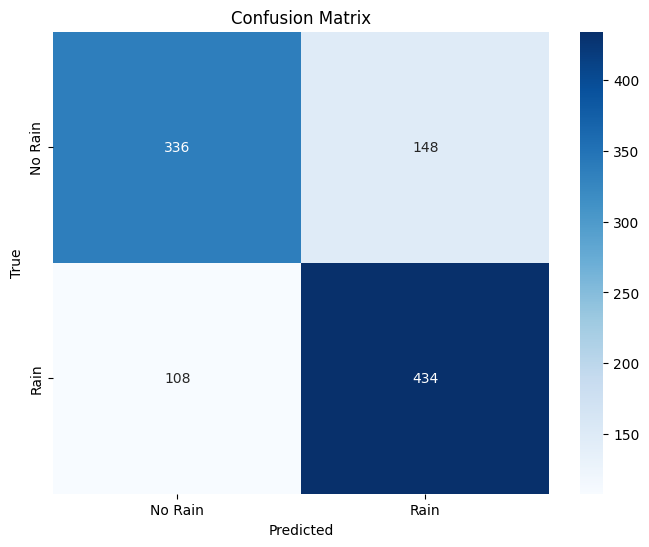

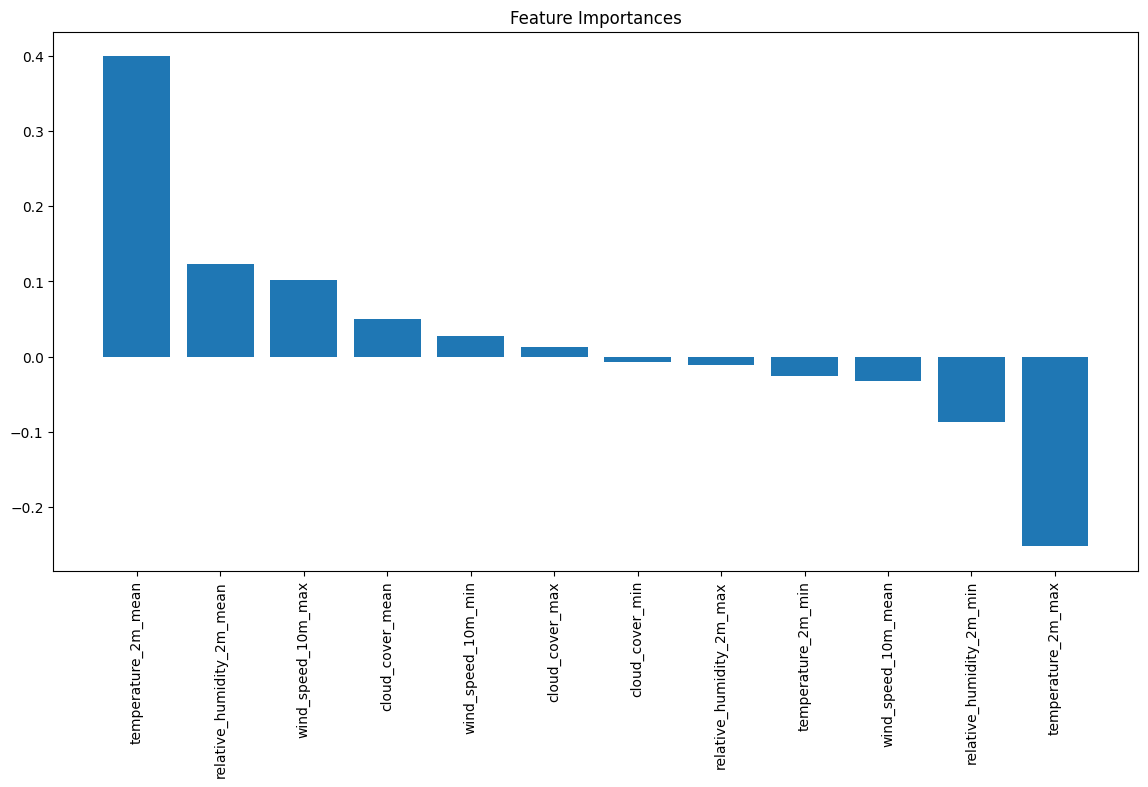

In [ ]:
# Define features and target variable
target = 'precipitation_<lambda>'
features = [col for col in daily_dataframe.columns if col != target and col not in ['rain_sum', 'snowfall_sum']]
X = daily_dataframe[features]
y = daily_dataframe[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression classifier
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importance visualization for logistic regression (coefficients)
coefficients = model.coef_[0]
indices = np.argsort(coefficients)[::-1]

plt.figure(figsize=(14, 7))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), coefficients[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()